# Fig 14

In [2]:
from data_import import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from plotting import *

device = 'cuda:0'

In [3]:
df_orig = load_result_table('feeds/phase_diagram_T32_L15').reset_index()
df_orig = df_orig[df_orig['epoch']==499]
figure_dir = FIGURE_DIR

In [4]:
allowed_p = [2,4,8,16,32,64,128,3, 6, 11, 23, 45, 91]
allowed_model_dim = [2,4,8,16,32,64,128,3, 6, 11, 23, 45, 91]

df_orig = df_orig[df_orig['p'].isin(allowed_p) & df_orig['model_dim'].isin(allowed_model_dim)]
df_orig.model_dim.unique(), df_orig.p.unique()

(array([ 91,  45,  23,  11,   6,   3, 128,  64,  32,  16,   8,   4,   2]),
 array([ 91,  45,  23,  11,   6,   3, 128,  64,  32,  16,   8,   4,   2]))

In [5]:
df = df_orig.groupby(CONFIG_COLS).mean(numeric_only=True).reset_index()
df_std = df_orig.groupby(CONFIG_COLS).std(numeric_only=True).reset_index()
df_max = df_orig.groupby(CONFIG_COLS).max(numeric_only=True).reset_index()

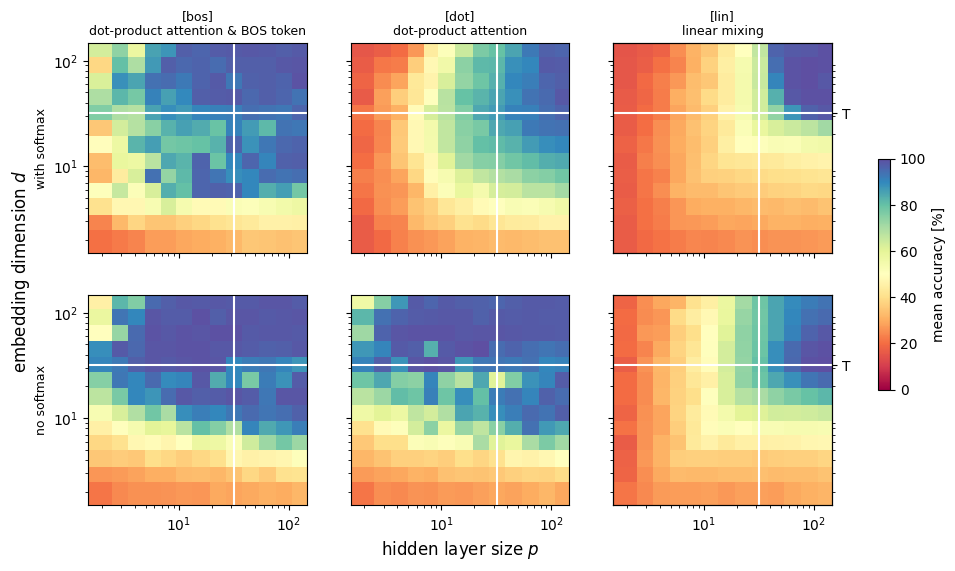

In [6]:
T = 32
L = 15
k = df[(df['T'] == T) & (df.seq_len == L) ]
k_std = df_std[(df_std['T'] == T) & (df_std.seq_len == L) ]
k_max = df_max[(df_std['T'] == T) & (df_std.seq_len == L) ]

fig, axes = plt.subplots(2,3,figsize=(12,6),sharex=True,sharey=True)

axes_assignment = {
        'linear': (1,2),
        'linear+sftm': (0,2),
        'dot': (1,1),
        'dot+sftm': (0,1),
        'dotBOS' : (1,0),
        'dotBOS+sftm': (0,0),
}

axes[axes_assignment['linear+sftm']].set_title('[lin]\nlinear mixing',fontsize=9)
axes[axes_assignment['dot+sftm']].set_title('[dot]\ndot-product attention',fontsize=9)
axes[axes_assignment['dotBOS+sftm']].set_title('[bos]\ndot-product attention & BOS token',fontsize=9)

axes[1,0].set_ylabel('no softmax',fontsize=9)
axes[0,0].set_ylabel('with softmax',fontsize=9)
axes[1,1].set_xlabel('hidden layer size $p$',fontsize=12)


for name, model_config in MODELS.items():
    ax = axes[axes_assignment[name]]
    a = k[(k.attention_input == model_config['attention_input'])
            & (k.no_softmax == model_config['no_softmax']) 
            & (k.dataset_type == model_config['dataset'])]
    a_std = k_std[(k_std.attention_input == model_config['attention_input'])
            & (k_std.no_softmax == model_config['no_softmax']) 
            & (k_std.dataset_type == model_config['dataset'])]
    a_max = k_max[(k_max.attention_input == model_config['attention_input'])
                & (k_max.no_softmax == model_config['no_softmax']) 
                & (k_max.dataset_type == model_config['dataset'])]
    
    if len(a) == 0:
        continue

    aother_mean = pd.pivot_table(a, index='p', columns='model_dim', values='val_acc')
    #aother_max = pd.pivot_table(a_max, index='p', columns='model_dim', values='best_val_acc')
    
    
    smap = ax.pcolor(aother_mean.index, aother_mean.columns, aother_mean.values.T, cmap='Spectral', vmin=0, vmax=100)
    
    ax.axvline(T,c='white')
    ax.axhline(T,c='white')
    #ax.axhline(np.log(T)+1,c='white')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    if 'linear' in name:
        ax2 = ax.twinx()
        ax2.set_yscale('log')
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks([T])
        ax2.set_yticklabels(['T'])
fig.text(0.06, 0.5, 'embedding dimension $d$', va='center', rotation='vertical',fontsize=12)
fig.colorbar(smap,ax=axes,location='right',shrink=0.5,label='mean accuracy [%]')
plt.savefig(figure_dir / 'memorizing_counts-phase-diagram-T32-L15-mean-best-marked.png',bbox_inches='tight')
plt.show()